# Whoosh: a fast pure-Python search engine library

## Pydata Madrid
## 2016.04.10

# Who am I?

Claudia Guirao Fernández   

@claudiaguirao 

Background: Double degree in Law and Business Administration

Data Scientist at PcComponentes.com

DjangoGirl, Python lover, learning enthusiast



# What is Whoosh?

*Whoosh is a library of classes and functions for indexing text and then searching the index. It allows you to develop custom search engines for your content.*


+ Whoosh is fast, but uses only pure Python, so it will run anywhere Python runs, without requiring a compiler.
+ It’s a programmer library for creating a search engine
+ Allows indexing, choose the level of information stored for each term in each field, parsing search queries, choose scoring algorithms, etc.


but...


+ All indexed text in Whoosh must be unicode.
+ Only runs in 2.7 NOT in python 3 

# Why Whoosh instead Elastic Search?


Why I personally choose whoosh instead other high performance solutions:



- I was focused on index / search definition
- 12k documents aprox.
- mb instead gb
- Fast development
- No compilers, no java


*If your are a begginer, you have no team, you need a fast solution, you need to work isolated or you have a small project this is your solution otherwise **Elastic Search** might be your tech.*


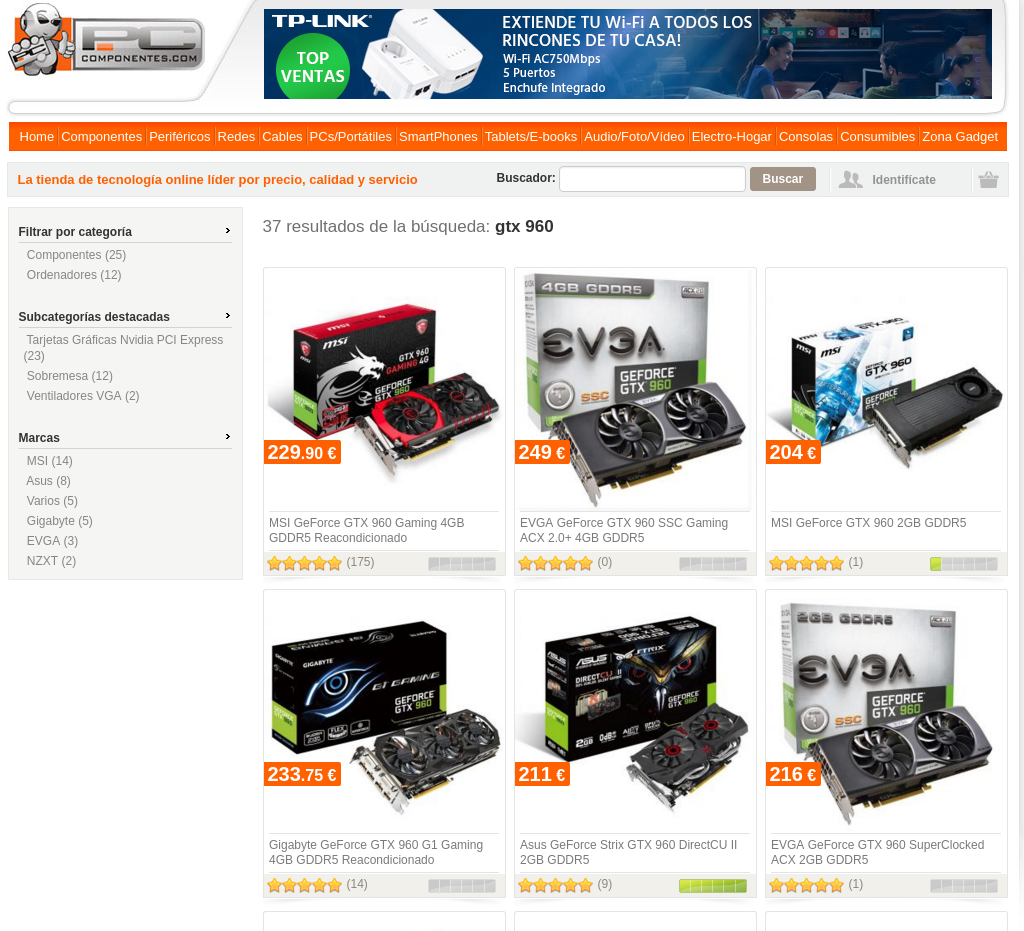

In [1]:
from IPython.display import Image
Image(filename='files/screenshot.png')


# Development stages

1. Data treatment
2. Schema
3. Index
4. Search
5. Other stuff

## Data Treatment

- Data set is available in csv format at www.pccomponentes.com > mi panel de cliente > descargar tarifa



- It is in *latin*, it has special characters and missing values


- No tags, emphasis and laboured phrasing, lots of irrelevant information mixed with the relevant information.

### **TONS OF FUN!**

In [2]:
import csv

catalog = csv.DictReader(open('files/catalogo_head.csv'))
for product in catalog:
    print product["Codigo"] + ' - ' + product["Articulo"]

76880 - Taurus Grill&Co Sandwichera Grill 1500W Reacondicionado
89478 - Aspirador de Automovil con Luz LED
90722 - Kit Manos Libres Bluetooth LCD Transmisor FM
67329 - Llavero con Alcoholímetro y Linterna
63847 - Unotec Antideslizante Plus Para Coche
86242 - Tronsmart TS-CC4PC Quick Charge 2.0 Cargador de Coche 4 USB
73184 - Unotec OBDII Diagnóstico Para Coche Bluetooth PC/Android


### TAGS

- Document: each product
- Corpus: catalog

#### TF-IDF 

*term frequency–inverse document frequency, reflects how important a word is to a document in a collection or corpus*


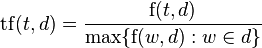

In [3]:
Image(filename='files/tf.png')



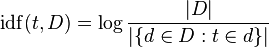

In [4]:
Image(filename='files/idf.png')

In [5]:
Image(filename='files/tfidf.png')

In [6]:
from nltk.corpus import stopwords
import csv

stop_words_spa = stopwords.words("spanish")
stop_words_eng = stopwords.words("english")
with open('files/adjetivos.csv', 'rb') as f:
    reader = csv.reader(f)
    adjetivos=[]
    for row in reader:
        for word in row:
            adjetivos.append(word)

In [7]:
import math
#tf-idf functions:

def tf(word, blob):
    return float(blob.words.count(word))/float(len(blob.words))

def idf(word, bloblist):
    return (float(math.log(len(bloblist)))/float(1 + n_containing(word, bloblist)))

def n_containing(word, bloblist):
    return float(sum(1 for blob in bloblist if word in blob))

def tfidf(word, blob, bloblist):
    return float(tf(word, blob)) * float(idf(word, bloblist))


In [8]:
import csv
from textblob import TextBlob as tb

catalog = csv.DictReader(open('files/catalogo_head.csv'))

bloblist = []

for product in catalog:
    text =unicode(product["Articulo"], encoding="utf-8", errors="ignore").lower()
    text = ' '.join([word for word in text.split() if word not in stop_words_spa])
    text = ' '.join([word for word in text.split() if word not in stop_words_eng])
    text = ' '.join([word for word in text.split() if word not in adjetivos])
    value = tb(text)
    bloblist.append(value)

tags = []

for blob in bloblist:
    scores = {word: tfidf(word, blob, bloblist) for word in blob.words}
    sorted_words = sorted(scores.items(), key=lambda x: x[1], reverse=True)
    terms = ''
    for word, score in sorted_words[:3]:
        terms = terms+word+' '
    tags.append(terms)
    
for t in tags:
    print unicode(t)


grill 1500w taurus 
aspirador luz led 
libres transmisor manos 
linterna llavero alcoholímetro 
antideslizante plus unotec 
ts-cc4pc usb tronsmart 
diagnóstico pc/android obdii 


### Other ideas

#### Use the search engine as tagger 

    e.g. all products with the word "kids" will be tagged as "child" ("niños" o "infantil")

#### Use the database as tagger 

    e.g. all smartphones below 150€ tagged as "cheap"


## * ** Teamwork is always better ***

*I had to collaborate with other departments, SEO and Cataloging *


## Schema

1. Types of fields:
 + TEXT : for body text, allows phrase searching. 
 + KEYWORD: space- or comma-separated keywords, tags
 + ID: single unit, e.g. prod
 + NUMERIC: int, long, or float, sortable format
 + DATETIME: sortable
 + BOOLEAN: users to search for yes, no, true, false, 1, 0, t or f.
 
2. Field boosting. * Is a multiplier applied to the score of any term found in the field.*      


### Form diversity
- Stemming *(great if you are working English)*
        Removes suffixes

- Variation *(great if you are working English)*
        Encodes the words in the index in a base form
        

In [9]:
from whoosh.lang.porter import stem
print "stemming: "+stem("analyse")

from whoosh.lang.morph_en import variations
print "variations: "
print list(variations("analyse"))[0:5]

stemming: analys
variations: 
['analysers', 'analyseful', 'analysest', 'analyse', 'analysed']


In [10]:
import csv   

catalog = csv.DictReader(open('files/catalogo_contags.csv'))
print list(catalog)[0].keys()


['Categoria', 'PVP', 'indice', 'Plazo', 'Ean', 'Marca/Fabricante', 'tags', 'Peso', 'P/N', 'Articulo', 'Codigo', 'PVP SIN IVA', 'Stock']


In [11]:
from whoosh.index import create_in
from whoosh.analysis import StemmingAnalyzer
from whoosh.fields import *

catalog = csv.DictReader(open('files/catalogo_contags.csv'))

data_set = []
for row in catalog:
    row["Categoria"] = unicode(row["Categoria"], encoding="utf-8", errors="ignore")
    row["Articulo"] = unicode(row["Articulo"], encoding="utf-8", errors="ignore")
    row["tags"] = unicode(row["tags"], encoding="utf-8", errors="ignore")
    row["Ean"] = unicode(row["Ean"], encoding="utf-8", errors="ignore")
    row["Codigo"] = unicode(row["Codigo"], encoding="utf-8", errors="ignore")
    row["PVP"] = float(row["PVP"])
    row["Plazo"] =  unicode(row["Plazo"], encoding="utf-8", errors="ignore")
    
    data_set.append(row)
print str(len(data_set)) + ' products'



11901 products


In [12]:
schema = Schema(Codigo=ID(stored=True), 
                Ean=TEXT(stored=True), 
                Categoria=TEXT(analyzer=StemmingAnalyzer(minsize=3),
                               stored=True),
                Articulo=TEXT(analyzer=StemmingAnalyzer(minsize=3), 
                              field_boost=2.0, stored=True), 
                Tags=KEYWORD(field_boost=1.0, stored=True), 
                PVP=NUMERIC(sortable = True),
                Plazo = TEXT(stored=True))


## Index


Whoosh allows you to:
- Create an index object in accordance with the schema 
- Merge segments:  an efficient way to add documents
- Delete documents in index: writer.delete_document(docnum)
- Update documents: writer.update_document
- Incremental index




In [13]:
from whoosh import index
from datetime import datetime
start = datetime.now()
ix = create_in("indexdir", schema)  #clears the index

#on a directory with an existing index will clear the current contents of the index

writer = ix.writer()

for product in data_set:
    writer.add_document(Codigo=unicode(product["Codigo"]),
                        Ean=unicode(product["Ean"]),
                        Categoria=unicode(product["Categoria"]),
                        Articulo=unicode(product["Articulo"]),
                        Tags=unicode(product["tags"]),
                        PVP=float(product["PVP"]))

writer.commit()

finish = datetime.now()
time = finish-start
print time

0:00:25.538168


#### *12k documents aprox stored in 10mb, index created in less than 15 seconds*


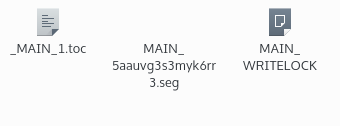

In [14]:
Image(filename='files/screenshot_files.png')

## Search

- Parsing
- Scoring: The default is BM25F, but you can change it. myindex.searcher(weighting=scoring.TF_IDF())
- Sorting: by scoring, by relevance, custom metrics
- Filtering: e.g. by category


### Parsing

Convert a query string submitted by a user into query objects

- Default parser: 
```QueryParser("content", schema=myindex.schema)
```

- MultifieldParser: Returns a QueryParser configured to search in multiple fields

- Whoosh also allows you to customize your parser. 




In [15]:
from whoosh.qparser import MultifieldParser, OrGroup

qp = MultifieldParser(["Categoria", 
                       "Articulo",
                       "Tags", 
                       "Ean",
                       "Codigo",
                       "Tags"],  # all selected fields
                        schema=ix.schema, # with my schema
                        group=OrGroup) # OR instead AND

user_query = 'Cargador de coche USB'
user_query = unicode(user_query, encoding="utf-8", errors="ignore")
user_query = user_query.lower()
user_query = ' '.join([word for word in user_query.split() if word not in stop_words_spa])
user_query = ' '.join([word for word in user_query.split() if word not in stop_words_eng])
print "this is our query: " + user_query

q = qp.parse(user_query)

print "this is our parsed query: " + str(q)


this is our query: cargador coche usb
this is our parsed query: (Categoria:cargador OR Articulo:cargador OR Tags:cargador OR Ean:cargador OR Codigo:cargador OR Categoria:coch OR Articulo:coch OR Tags:coche OR Ean:coche OR Codigo:coche OR Categoria:usb OR Articulo:usb OR Tags:usb OR Ean:usb OR Codigo:usb)


In [16]:
with ix.searcher() as searcher:
    results = searcher.search(q)
    print str(len(results))+' hits'
    print results[0]["Codigo"]+' - '+results[0]["Articulo"]+' - '+results[0]["Categoria"]



942 hits
53516 - Cargador Doble USB Coche - Accesorios Automóvil


### Sorting

We can sort by any field that is previously marked as sortable in the schema. 

```python
PVP=NUMERIC(sortable=True)
```


In [17]:
with ix.searcher() as searcher:
    print '''
    ----------- word-scoring sorting ------------
    '''
    results = searcher.search(q)
    for hit in results:
        print hit["Articulo"]+' - '+str(hit["PVP"])+' eur'
    print '''
    --------------- PVP sorting -----------------    
    '''
    results = searcher.search(q, sortedby="PVP")
    for hit in results:
        print hit["Articulo"]+' - '+str(hit["PVP"])+' eur'


    ----------- word-scoring sorting ------------
    
Cargador Doble USB Coche - 9 eur
Cargador de coche USB Negro - 3 eur
Cargador de coche micro USB - 5 eur
Cargador de coche USB Blanco - 3 eur
TomTom Cargador USB para Coche - 15 eur
Conceptronic Cargador Coche USB - 6 eur
Aukey CC-01 Cargador de Coche 4 puertos USB - 15 eur
Conceptronic Cargador Coche Universal Micro USB - 8 eur
Aukey CC-Y3 Quick Charge Cargador de Coche USB/USB-C - 15 eur
Aukey CC-T1 Quick Charge 2.0 Cargador Coche 1+1 USB - 15 eur

    --------------- PVP sorting -----------------    
    
Adaptador de enchufe Americano a  Europeo - 1 eur
Cable USB 2.0 AM/AH Alargador Macho/Hembra 1.8m - 1 eur
Adaptador USB Macho a USB Macho - 1 eur
Adaptador Mini USB Hembra a Micro USB Macho - 1 eur
Cable USB 2.0 a Mini USB 1m M/M - 1 eur
Cable USB 2.0 a Mini USB 1.8m M/M - 1 eur
Cable USB 2.0 a MicroUSB 1m M/M - 1 eur
Cable Adaptador Micro USB OTG - 1 eur
Cable USB 2.0 AM/AM 1.8m - 1 eur
Cable USB 2.0 a Mini USB 0.8m M/M - 1 e

### Filtering

Whoosh allows you to filter, in positive and negative, also by multiple fields. 

```python
allow_q = query.Term("Stock","Si")
```


```python
restrict_q = query.Term("Stock", "No")
```

And the search function will looks like this:


```python
results = searcher.search(q, filter=allow_q, mask=restrict_q)
```


## Other stuff

- It is running with ** Flask with wsgi tornado **

- [Flask-WhooshAlchemy](https://pythonhosted.org/Flask-WhooshAlchemy/)


### **Future developments:**


+ Did you mean...?: it is developing at front with Levenshtein_distance

+ Related search:  Apriori Algoritm

+ Search-as-you-type




# Q & A 

## Thank you for your attention!



[Slides at PydataMad Github](https://github.com/PyDataMadrid2016/)

### @claudiaguirao
